In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# # Create your connection.
conn = sqlite3.connect('fast_dhsvm_parallel_run_raw_liv.db')

simulations = pd.read_sql_query("SELECT * FROM fast_dhsvm_parallel_run_raw_liv", conn)
validation = pd.read_csv('validation.csv')
print("Number of Runs:", len(simulations))
simulations.groupby(['chain']).size()

Number of Runs: 10


chain
1.0    10
dtype: int64

In [3]:
simulations.head()

,like1,parRain_threshold,parSnow_Threshold,simulation_0,simulation_1,simulation_2,simulation_3,simulation_4,simulation_5,simulation_6,...,simulation_209,simulation_210,simulation_211,simulation_212,simulation_213,simulation_214,simulation_215,simulation_216,simulation_217,chain
0,0.6523,-1.596,0.402600,29.48,27.48,27.03,27.62,28.60,29.34,29.61,...,99.56,97.80,96.50,95.25,94.10,93.06,92.10,91.30,90.50,1.0
1,0.6597,-1.596,-0.396500,29.48,27.48,27.03,27.64,28.60,29.36,29.66,...,103.60,101.60,100.06,98.75,97.50,96.30,95.25,94.30,93.44,1.0
2,0.6606,-1.596,-0.801000,29.48,27.48,27.05,27.64,28.60,29.36,29.66,...,105.94,103.75,102.00,100.60,99.25,98.06,96.94,95.94,95.00,1.0
3,0.6567,-1.596,-0.001935,29.48,27.48,27.03,27.64,28.58,29.34,29.64,...,101.56,99.75,98.25,97.00,95.80,94.70,93.70,92.80,92.00,1.0
4,0.6470,-1.596,0.797400,29.48,27.48,27.03,27.64,28.60,29.33,29.58,...,97.70,96.06,94.75,93.60,92.50,91.56,90.70,89.90,89.06,1.0


In [5]:
streamflow_only = 'output/DHSVMoutput_raw_liv_2006flood/Streamflow.Only'

with open(streamflow_only, 'r') as file_output:
            header_name = file_output.readlines()[0].split(' ')

with open(streamflow_only) as inf:
            next(inf)
            date_q = []
            q_12189500 = []
            for line in inf:
                parts = line.split()
                if len(parts) > 1:
                    date_q.append(parts[0])
                    q_12189500.append(float(parts[2])/(3600*3))

Simulation_streamflow = pd.DataFrame({'x[0]':date_q, 'x[2]':q_12189500})
Simulation_streamflow.columns = [header_name[0], header_name[2]]
Simulation_streamflow = Simulation_streamflow[:-14]
Simulation_streamflow.to_csv('Benchmark.csv',index = False)
Simulation_streamflow = pd.read_csv('Benchmark.csv') 
Benchmark = Simulation_streamflow['12189500'].values

In [6]:
simulation_subset = simulations.loc[simulations['like1'].idxmax()]
validation['best'] = simulation_subset[simulation_subset.index.str.contains('simulation')].values
validation['benchmark'] = Benchmark
validation.columns = ['Date','Observed', 'Simulation_best','Benchmark']

In [7]:
results=simulations.to_records(index=False)

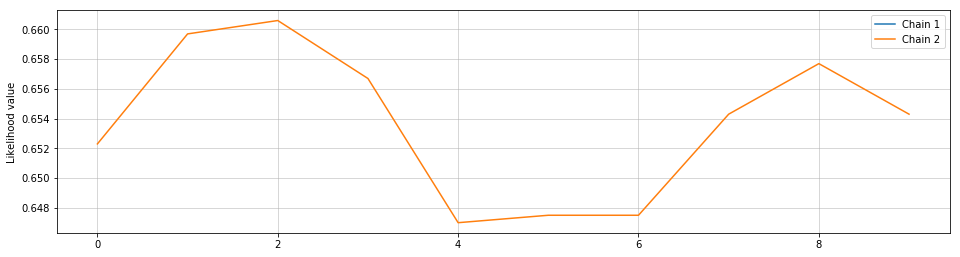

In [8]:
fields=[word for word in results.dtype.names if word.startswith('sim')]
fig= plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
for i in range(int(float(max(results['chain'])))+1):
    res_chains = np.array([int(float(r)) for r in results['chain']])
    index=np.where(res_chains==i)
    plt.plot(results['like1'][index], label='Chain '+str(i+1))

plt.ylabel('Likelihood value')
plt.legend()
plt.grid(linewidth=0.5)
# ax =plt.subplot(2,1,2)

# r_hat = np.load('outfile.npy')
# r_hat=np.array(r_hat)
# ax.plot([1.2]*len(r_hat),'k--')
# for i in range(len(r_hat[0])):
#     ax.plot(r_hat[:,i],label='x'+str(i+1))

# ax.set_yscale("log", nonposy='clip')
# ax.set_ylim(-1,50)
# ax.set_ylabel('R$^d$ - convergence diagnostic')
# plt.xlabel('Number of chainruns')
# plt.legend()
# fig.savefig('python_hymod_convergence.png',dpi=300)

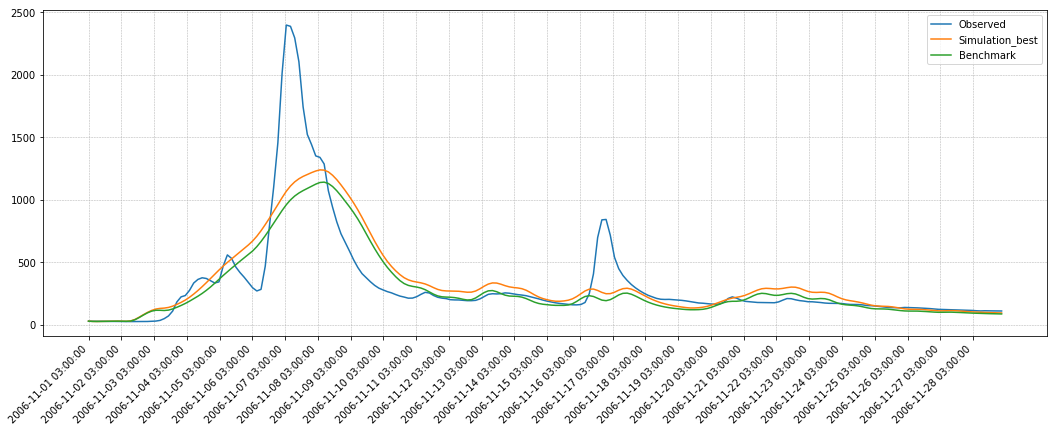

In [9]:
di = pd.date_range(min(validation.Date), max(validation.Date), freq='D')
plt.figure(figsize=(18, 6))

# testing
date_indices = []
st = 0
for i in range(len(di)):
    date_indices.append(st)
    st += len(validation)/len(di)
    
plt.xticks(date_indices, di, rotation=45, ha='right')
plt.plot(validation.Date, validation.Observed)
plt.plot(validation.Date, validation.Simulation_best)
plt.plot(validation.Date, validation.Benchmark)

plt.legend()
plt.grid(linewidth=0.5, linestyle='--')

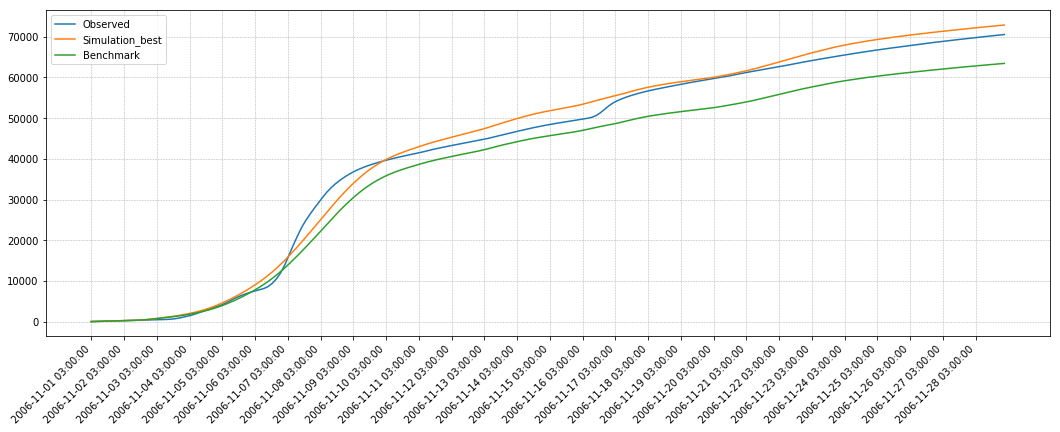

In [10]:
cumulative_sum = validation.set_index('Date')
cumulative_sum = cumulative_sum.sort_index().cumsum()
cumulative_sum = cumulative_sum.reset_index()

di = pd.date_range(min(validation.Date), max(validation.Date), freq='D')
plt.figure(figsize=(18, 6))
date_indices = []
st = 0
for i in range(len(di)):
    date_indices.append(st)
    st += len(cumulative_sum)/len(di)
plt.xticks(date_indices, di, rotation=45, ha='right')
plt.plot(cumulative_sum.Date, cumulative_sum.Observed)
plt.plot(cumulative_sum.Date, cumulative_sum.Simulation_best)
plt.plot(cumulative_sum.Date, cumulative_sum.Benchmark)
plt.legend()
plt.grid(linewidth=0.5, linestyle='--')

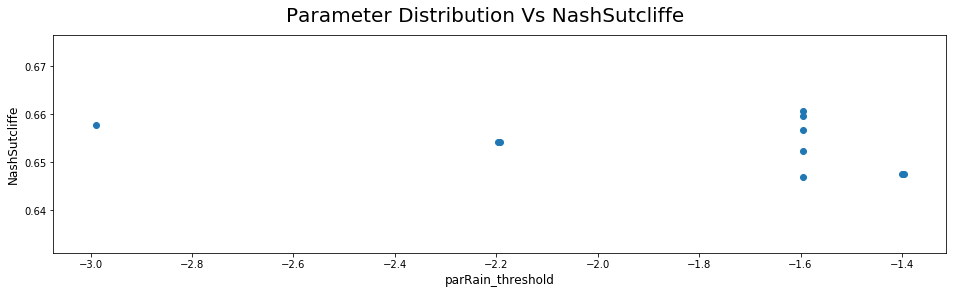

In [11]:
plt.figure(figsize=(16,4))
plt.scatter(simulations['parRain_threshold'], simulations['like1'])
plt.xlabel('parRain_threshold', fontsize=12)
plt.ylabel('NashSutcliffe', fontsize=12)
plt.suptitle('Parameter Distribution Vs NashSutcliffe', fontsize=20)
plt.show()
